In [1]:
%matplotlib inline
import sys
sys.path.append("/home/mette/github/implicitmodules")


# Fitting an image and points

In this example, we will fit a cross onto the same cross, but rotated. We will take advantage of this knowledge and use a rotation deformation module. We will also add some noise on the initial center guess to show how to fit the geometrical descriptors. In addition to images, we add points at the extremity of each branch that will also get matched in order to illustrate multi deformables matching. This also helps the fitting process by adding more information to the model.




Import relevant modules.




In [2]:
import sys
sys.path.append("../")

import math

import torch
import matplotlib.pyplot as plt
import scipy.ndimage
import numpy as np
from os import listdir
from os.path import isfile, join
from tqdm import tqdm

import imodal

imodal.Utilities.set_compute_backend('torch')

In [3]:
def load_volume(filepath):
    files = [file for file in np.sort(listdir(filepath)) if file.endswith(".npy")]
    height, width = np.load(join(filepath,files[0])).shape
    depth = len(files)
    volume = np.zeros((depth, height, width))
    for i,file in tqdm(enumerate(files)):
        volume[i,:,:] = np.load(join(filepath,file))

    volume = volume[:,:,:].astype('float32')
    return volume

In [4]:
num_angles = 30#number of angles pr. frame

strt_stp_idx = int(num_angles/2)
ground_truth = load_volume("../../PhantomGenerator/output/slow_fast_no_rotation")[strt_stp_idx:-strt_stp_idx,106:406,106:406]

240it [00:00, 364.93it/s]


Load image data and generate dots.




In [5]:
source_image = torch.from_numpy(ground_truth[0,:,:])
target_image = torch.from_numpy(ground_truth[-1,:,:])

extent = imodal.Utilities.AABB(0., 300., 0., 300.)

source_dots = torch.tensor([[-19., -20.],
                     [70., 32.]])+150

target_dots = torch.tensor([[-8., -7.],
                     [39., 40.]])+150

source_dots, target_dots

(tensor([[131., 130.],
         [220., 182.]]),
 tensor([[142., 143.],
         [189., 190.]]))

In [6]:
extent.totuple()

(0.0, 300.0, 0.0, 300.0)

Plot everything.




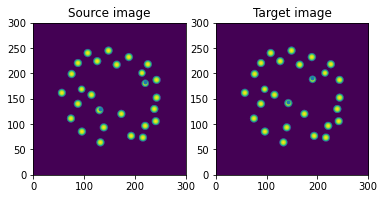

In [7]:
plt.subplot(1, 2, 1)
plt.title("Source image")
plt.imshow(source_image, extent=extent.totuple(), origin="lower")
plt.plot(source_dots.numpy()[:, 0], source_dots.numpy()[:, 1], '.')
#plt.plot(center.numpy()[:, 0], center.numpy()[:, 1], '.')

plt.subplot(1, 2, 2)
plt.title("Target image")
plt.imshow(target_image, extent=extent.totuple(), origin="lower")
plt.plot(target_dots.numpy()[:, 0], target_dots.numpy()[:, 1], '.')

plt.show()

We know that the target image is the result of some translation at the given points,
so we use a local translation deformation module. Can we add some imprecision to the source and target points?

In [8]:
shift = target_dots-source_dots
shift

tensor([[ 11.,  13.],
        [-31.,   8.]])

In [9]:
sigma = 12.0 #determines area affected by local translation
d = 2 #dimension
p = 2 #number of sources

nu = 0.1 #regularization parameter
implicit_translation = imodal.DeformationModules.ImplicitModule0(d, p, sigma, nu=nu)

gd = source_dots
controls = shift

implicit_translation.manifold.fill_gd(gd)
implicit_translation.fill_controls(controls)

Create the grid

In [10]:
grid_points = imodal.Utilities.grid2vec(*torch.meshgrid([torch.linspace(0., 300., 100), torch.linspace(0., 300., 100)]))

Plot the module

(0.0, 300.0, 0.0, 300.0)

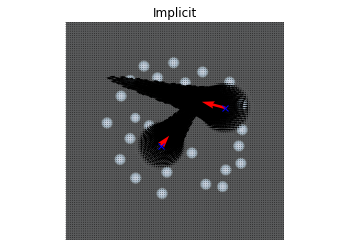

In [11]:
implicit_field = implicit_translation(grid_points)
plt.title("Implicit")
plt.quiver(grid_points[:, 0], grid_points[:, 1], implicit_field[:, 0]*0.00001, implicit_field[:, 1]*0.00001)
plt.plot(gd[:, 0], gd[:, 1], 'x', color='blue')
plt.quiver(gd[:, 0], gd[:, 1], controls[:, 0]*0.001, controls[:, 1]*0.001, color='red', lw=1.5)
plt.imshow(source_image, cmap="gray", extent=extent, alpha=0.8, origin="lower")
plt.imshow(target_image, cmap="Blues", extent=extent, alpha=0.2, origin="lower")
plt.axis('equal')
plt.axis('off')

Create the model by setting `True` for `fit_gd` so that it also optimize the
rotation center.




In [12]:
source_deformable = imodal.Models.DeformableImage(source_image, output='bitmap', extent='match', backward=True)
target_deformable = imodal.Models.DeformableImage(target_image, output='bitmap', extent='match', backward=True)

source_dots_deformable = imodal.Models.DeformablePoints(source_dots)
target_dots_deformable = imodal.Models.DeformablePoints(target_dots)

attachment = imodal.Attachment.L2NormAttachment(transform=None)

model = imodal.Models.RegistrationModel([source_deformable, source_dots_deformable], [implicit_translation], [attachment, imodal.Attachment.EuclideanPointwiseDistanceAttachment()], fit_gd=[False], lam=1000.)

Fit the model.




In [13]:
shoot_solver = 'euler'
shoot_it = 10
max_it = 100

costs = {}
fitter = imodal.Models.Fitter(model, optimizer='torch_lbfgs')

fitter.fit([target_deformable, target_dots_deformable], max_it, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

/home/mette/github/implicitmodules/imodal/DeformationModules/ImplicitModule0.py:111: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /tmp/pip-req-build-019a0thw/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  controls, _ = torch.solve(vs(self.manifold.gd), K_q)


Starting optimization with method torch LBFGS, using solver euler with 10 iterations.
Initial cost={'deformation': 0.0, 'attach': 71894.6953125}
1e-10
Evaluated model with costs=71894.6953125
Evaluated model with costs=71430.69791027904
Evaluated model with costs=71046.93638281524
Evaluated model with costs=68819.62089300156
Evaluated model with costs=47344.696716308594
Evaluated model with costs=149397.70947265625
Evaluated model with costs=33873.73034667969
Evaluated model with costs=68923.8046875
Evaluated model with costs=31195.679809570312
Evaluated model with costs=61881.39318847656
Evaluated model with costs=25494.098754882812
Evaluated model with costs=40919.912841796875
Evaluated model with costs=23236.564208984375
Evaluated model with costs=30022.66778564453
Evaluated model with costs=21541.643188476562
Evaluated model with costs=22359.523559570312
Evaluated model with costs=20451.723388671875
Evaluated model with costs=19372.709716796875
Evaluated model with costs=17840.0266

Evaluated model with costs=5972.776611328125
Evaluated model with costs=5979.089599609375
Evaluated model with costs=5973.47265625
Evaluated model with costs=5972.810791015625
Evaluated model with costs=5972.7412109375
Evaluated model with costs=5972.9560546875
Evaluated model with costs=5972.7392578125
Evaluated model with costs=5973.533203125
Evaluated model with costs=5972.77587890625
Evaluated model with costs=5972.744384765625
Evaluated model with costs=5972.695556640625
Evaluated model with costs=5972.511962890625
Evaluated model with costs=5971.98388671875
Evaluated model with costs=5971.629150390625
Evaluated model with costs=5971.288818359375
Evaluated model with costs=5971.08251953125
Evaluated model with costs=5970.956787109375
Evaluated model with costs=5970.89501953125
Evaluated model with costs=5970.796142578125
Evaluated model with costs=5970.743408203125
Evaluated model with costs=5970.661865234375
Evaluated model with costs=5970.534423828125
Evaluated model with costs=

Plot total cost evolution.




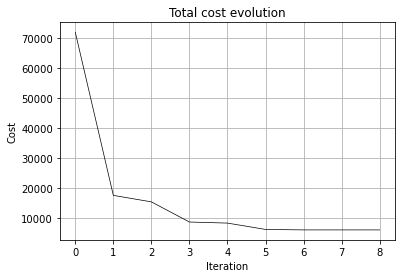

In [14]:
total_costs = [sum(cost) for cost in list(map(list, zip(*costs.values())))]

plt.title("Total cost evolution")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.plot(range(len(total_costs)), total_costs, color='black', lw=0.7)
plt.show()

Compute the final deformed source and plot it.




[(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]),), (tensor([[142.0000, 142.9999],
        [188.9999, 189.9999]]),)]


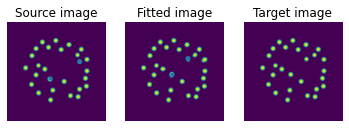

In [15]:
with torch.autograd.no_grad():
    model.deformables[0].output = 'bitmap'
    deformed = model.compute_deformed(shoot_solver, shoot_it)
    print(deformed)

    deformed_image = deformed[0][0]#.view_as(source_image)
    deformed_dots = deformed[1][0]

plt.subplot(1, 3, 1)
plt.title("Source image")
plt.imshow(source_image.numpy(), extent=extent.totuple(), origin="lower")
plt.plot(source_dots.numpy()[:, 0], source_dots.numpy()[:, 1], '.')
#plt.plot(center.numpy()[0, 0], center.numpy()[0, 1], 'X')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Fitted image")
plt.imshow(deformed_image.numpy(), extent=extent.totuple(), origin="lower")
#plt.imshow(source_image.numpy(), extent=extent.totuple(), alpha=0.5, cmap="Blues")
plt.plot(deformed_dots.numpy()[:, 0], deformed_dots.numpy()[:, 1], '.')
#plt.plot(fitted_center.numpy()[0, 0], fitted_center.numpy()[0, 1], 'X')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Target image")
plt.imshow(target_image.numpy(), extent=extent.totuple(), origin="lower")
#plt.plot(target_dots.numpy()[:, 0], target_dots.numpy()[:, 1], '.')
plt.axis('off')

plt.show()

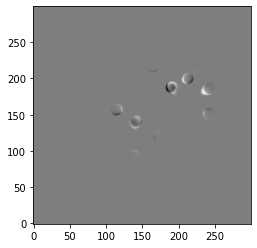

In [16]:
plt.imshow(deformed_image-target_image, origin="lower", cmap="gray")

In [17]:
import copy
modules = imodal.DeformationModules.CompoundModule(copy.copy(model.modules))
modules.manifold.fill(model.init_manifold.clone())

aabb = extent
square_size = 1.
grid_resolution = [math.floor(aabb.width/square_size),
                   math.floor(aabb.height/square_size)]

deformation_grid = imodal.DeformationModules.DeformationGrid(aabb, grid_resolution)

In [18]:
modules_grid = [*modules, deformation_grid]
hamiltonian = imodal.HamiltonianDynamic.Hamiltonian(modules_grid)

intermediates_grid = {}
with torch.autograd.no_grad():
    imodal.HamiltonianDynamic.shoot(hamiltonian, shoot_solver, shoot_it, intermediates=intermediates_grid)

In [19]:
with torch.autograd.no_grad():
    imodal.HamiltonianDynamic.shoot(hamiltonian, shoot_solver, shoot_it)
    
hamiltonian

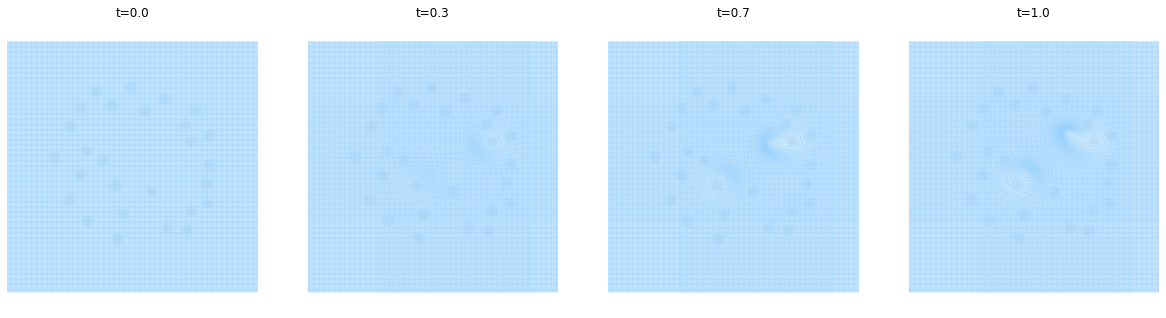

In [20]:
from scipy import interpolate
display_index = [0, 3, 7, 10]
plt.figure(figsize=[4.*len(display_index), 4.])
for count, i in enumerate(display_index):
    ax = plt.subplot(1, len(display_index), 1+count)
    ax.set_title("t={}".format(i/10.))


    deformation_grid.manifold.fill_gd(intermediates_grid['states'][i][-1].gd)
    grid_x, grid_y = deformation_grid.togrid()

    imodal.Utilities.plot_grid(ax, grid_x, grid_y, color='xkcd:light blue', lw=0.4)
    
    #plt.imshow(deformed_i.reshape((300,300)), extent=extent.totuple())
    plt.imshow(source_image.numpy(), extent=extent.totuple(), alpha=0.1, cmap="Blues", origin="lower")
    #plt.scatter(deformed_i[::2,0], deformed_i[::2,1])
    #imodal.Utilities.plot_closed_shape(source, color='black')
    #imodal.Utilities.plot_closed_shape(target, color='red')

    #imodal.Utilities.plot_closed_shape(deformed_i, color='blue')
    plt.axis('equal')
    plt.axis('off')

plt.subplots_adjust(left=0., right=1., top=1., bottom=0.)
plt.show()

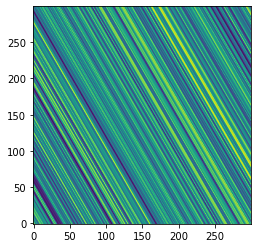

In [24]:
from scipy.interpolate import interp1d

def rotate(origin, points, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin

    qx = ox + np.cos(angle) * (points[:,0] - ox) - np.sin(angle) * (points[:,1] - oy)
    
    return qx

def map_grid(grid, model, t):
    modules = imodal.DeformationModules.CompoundModule(copy.copy(model.modules))
    modules.manifold.fill(model.init_manifold.clone())
    
    modules_grid = [*modules, grid]
    hamiltonian = imodal.HamiltonianDynamic.Hamiltonian(modules_grid)
    
    intermediates_grid = {}
    with torch.autograd.no_grad():
        imodal.HamiltonianDynamic.shoot(hamiltonian, shoot_solver, shoot_it, intermediates=intermediates_grid)
    
    grid.manifold.fill_gd(intermediates_grid['states'][t][-1].gd)    
    

def backprojection(data, theta, model, img_grid, rho, t):
    map_grid(img_grid, model, t)
    new_x, new_y = img_grid.togrid()
    grid_stack = np.stack((new_x.numpy().ravel(), new_y.numpy().ravel()), axis=-1)
    origin = np.subtract(img_grid.aabb.kmax, img_grid.aabb.kmin)/2
    #rotate mapped points to find out which sinogram value to backproject to which image pixel
    r = rotate(origin, grid_stack, theta)
    #interpolate sinogram data for given theta to be able to evaluate at found r values
    spl = interp1d(rho, data)
    return spl(r).reshape(new_x.shape)#backprojection = spl(r)#.reshape(new_x.shape)
    
aabb = extent
square_size = 1.
grid_resolution = [math.floor(aabb.width/square_size),
                   math.floor(aabb.height/square_size)]

img_grid = imodal.DeformationModules.DeformationGrid(aabb, grid_resolution)
    
data = np.random.rand(448)
bp = backprojection(data, -np.pi/3, model, img_grid, np.linspace(-75,374, 448), 0)
plt.imshow(bp, origin="lower")